In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import gzip
import re
from collections import defaultdict

import numpy as np
import pandas as pd

In [3]:
review_full = pd.read_csv('data/review.tsv.gz',sep='\t')
tip_full = pd.read_csv('data/tip.tsv.gz',sep='\t')
business_full = pd.read_csv('data/business.tsv.gz',sep='\t')
checkin_full = pd.read_csv('data/checkin.tsv.gz',sep='\t')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#rs = review_full.drop(['cool','date','funny','type','useful','user_id'],1)
#rs = rs[['business_id','text','stars']]
#rs.to_csv('out.dat',header=False,sep='|')

In [5]:
if True:
    user_valid = review_full.groupby('user_id').count()
    review_sub = review_full[review_full.user_id.isin(list(user_valid[user_valid.business_id > 20].index))]

    print review_full.shape,review_sub.shape,business_full.shape,tip_full.shape,checkin_full.shape
    review = review_sub#.sample(frac=0.01, replace=False)
    business = business_full[business_full.business_id.isin(list(review.business_id.unique()))]
    tip = tip_full[tip_full.business_id.isin(list(review.business_id.unique()))]
    checkin = checkin_full[checkin_full.business_id.isin(list(review.business_id.unique()))]
    print review.shape,business.shape,tip.shape,checkin.shape
else:
    review = review_full
    tip = tip_full
    business = business_full
    checkin = checkin_full

(2577313, 10) (797099, 10) (48485, 16) (602833, 6) (46417, 3)
(797099, 10) (45352, 16) (599707, 6) (43848, 3)


In [6]:
categories = defaultdict(int)
for row,cnt in zip(business.categories,business.review_count):
    for ct in row.strip('[]').split(','):
        categories[ct.strip()] += cnt
cats = sorted([(v,k) for k,v in categories.iteritems()])[::-1]

In [7]:
good_cats = []

if False:
    small_bus = business.loc[:,['business_id','categories']]
    for cnt, cat in cats:
        small_bus[cat] = small_bus.categories.str.contains(re.escape(cat))
    small_bus = small_bus.loc[:,[k for k in small_bus.columns if k != 'categories']]
    users = review.loc[:,['user_id','business_id','stars']]
    all_reviews = users.merge(small_bus,on='business_id')
    log_or = all_reviews.groupby('user_id').sum()
    if True:
        with open("filtered_100.txt") as fp:
            for line in fp:
                cnt, label = line.split(',')
                good_cats.append(label.strip())

    cand_cats = [cat for cnt,cat in cats if cat not in good_cats]
    while len(cand_cats) > 0:
        cnts = []
        if len(good_cats) > 0:
            good_filter = log_or[good_cats[0]] > 0
            for i in xrange(1,len(good_cats)):
                good_filter = good_filter & (log_or[good_cats[1]] > 0)
        for cat in cand_cats:
            if len(good_cats) > 0:
                cnts.append(((log_or[(log_or[cat] >0) & good_filter].shape[0],cat)))
            else:
                cnts.append((log_or[log_or[cat] > 0].shape[0],cat))

        cnts = sorted(cnts)[::-1]
        if cnts[0][0] > 500:
            good_cats.append(cnts[0][1])
            cand_cats.remove(cnts[0][1])
            print cnts[0]
        else:
            break

In [8]:
if len(good_cats) > 0:
    valid_cats = good_cats[:]
    print len(valid_cats)
elif True:
    with open("filtered_100.txt") as fp:
        for line in fp:
            cnt, label = line.split(',')
            good_cats.append(label.strip())
    valid_cats = good_cats[:50]
    print len(valid_cats)
else:
    print len(cats)
    valid_cats = [k for v,k in cats[:35]]
    print valid_cats

small_bus = business.loc[:,['business_id','categories']]
small_bus['biz_review'] = business.stars
for cat in valid_cats:
    small_bus[cat] = small_bus.categories.str.contains(re.escape(cat))
small_bus = small_bus.loc[:,[k for k in small_bus.columns if k != 'categories']]

50


In [9]:
users = review.loc[:,['user_id','business_id','stars']]

In [10]:
#users['liked'] = users.stars > 3.0

In [11]:
all_reviews = users.merge(small_bus,on='business_id')

In [24]:
#liking
grps = all_reviews.groupby(['business_id']).count() > 200
valid_biz = grps['stars'][grps['stars'] == True].index

sub_reviews = all_reviews[all_reviews.business_id.isin(valid_biz)]

grps = sub_reviews.groupby(['user_id']).count() > 50
valid_users = grps['stars'][grps['stars'] == True].index
sub_reviews = sub_reviews[sub_reviews.user_id.isin(valid_users)]

new_reviews = pd.DataFrame()
for cat in valid_cats:
    #new_reviews[cat]= all_reviews[all_reviews[cat]].groupby('user_id').mean()['stars'] > 3
    #new_reviews[cat]= all_reviews[all_reviews[cat]].groupby('user_id').mean()['stars'] > all_reviews[all_reviews[cat]].groupby('user_id').mean()['biz_review']
    #new_reviews[cat]= all_reviews[all_reviews[cat]].groupby(['user_id','business_id']).mean()['stars'] > all_reviews[all_reviews[cat]].groupby(['user_id','business_id']).mean()['biz_review']
    new_reviews[cat]= sub_reviews[sub_reviews[cat]].groupby('user_id').mean()['stars'] - sub_reviews[sub_reviews[cat]].groupby('user_id').mean()['biz_review']
    data_sample = new_reviews
#visting
from sklearn.linear_model import Lasso
ds = data_sample.copy().transpose()
for did, data in data_sample.transpose().iteritems():
    clf = Lasso(0.001,fit_intercept=False)
    clf.fit()
    
    print did, 
#data_sample = all_reviews.loc[:,[k for k in small_bus.columns if k not in ['user_id','business_id','stars']]]
data_sample.shape, all_reviews.shape # (1500, 21) or (28,51) or (500,35)

3nDUQBjKyVor5wV0reJChg (50,)
8DEyKVyplnOcSKx39vatbg (50,)
8OeTLey-p-WaL9ErNEci1Q (50,)
B1829_hxXSEpDPEDJtYeIw (50,)
C2C0GPKvzWWnP57Os9eQ0w (50,)
DK57YibC5ShBmqQl97CKog (50,)
JaqcCU3nxReTW2cBLHounA (50,)
N3oNEwh0qgPqPP3Em6wJXw (50,)
PKEzKWv_FktMm2mGPjwd0Q (50,)
QJI9OSEn6ujRCtrX06vs1w (50,)
RBZ_kMjowV0t6_nv2UKaDQ (50,)
S5dGv1vID1hoBZm2A9fK5g (50,)
S9Jw00eZHVj5_0sOM_C5Rg (50,)
SCo1UBoeN3bhRMkSYuiX1A (50,)
TdYKJgSgY2GF_YJnwsi5yQ (50,)
U4INQZOPSUaj8hMjLlZ3KA (50,)
UYcmGbelzRa0Q6JqzLoguw (50,)
YIMeEHUYm69m-Mqf-NjPHw (50,)
YMgZqBUAddmFErxLtCfK_w (50,)
_7PfR6Tvh2xTbiVi1GELoQ (50,)
_VMGbmIeK71rQGwOBWt_Kg (50,)
bLbSNkLggFnqwNNzzq-Ijw (50,)
cMEtAiW60I5wE_vLfTxoJQ (50,)
dIIKEfOgo0KqUfGQvGikPg (50,)
d_TBs6J3twMy9GChqUEXkg (50,)
eZZyuJDouIg4p-GYB3PV_A (50,)
epkRB3J_oBEiyiwahvdmGg (50,)
iSC96O2NjQc3JExGUHQG0Q (50,)
kjeX2RXvW7RhBbD2QLd5jA (50,)
kmE8w5Y785eZmodsx0V6Ag (50,)
n86B7IkbU20AkxlFX_5aew (50,)
niKu4se6xtf-ctlm0udr1w (50,)
oeAhRa8yFa9jtrhaHnOyxQ (50,)
p_azadim_uWFOXAhhKB3ag (50,)
pwQ8E-hbDUJe3q

((41, 50), (797099, 54))

In [17]:
#tmp_sample = data_sample#.dropna()
#int_cols = tmp_sample.fillna(0).astype(int)-1*((1.0 - tmp_sample.fillna(1).astype(int))) #astype(np.int)

#from pylab import *
#hist(np.array(int_cols.corr()).ravel())
#show()
#np.sum(int_cols.corr() > 0.25)
data_sample.fillna(0)
from sklearn.manifold import TSNE
model = TSNE(n_components=2, init='random',metric='euclidean')
pts = model.fit_transform(np.array(data_sample.fillna(0)).T)

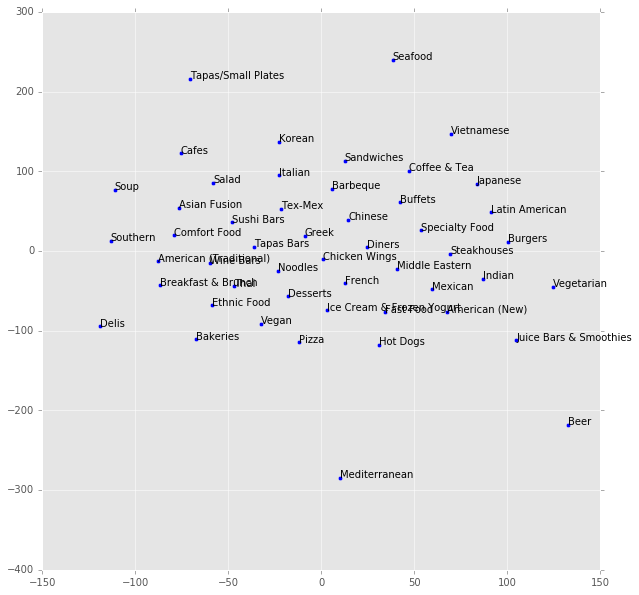

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(10,10))
plt.scatter(pts[:,0],pts[:,1])
for i, txt in enumerate(data_sample.columns):
    plt.gca().annotate(txt, (pts[i,0],pts[i,1]))

# Model Fitting

In [255]:
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import ConstraintBasedEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator

In [256]:
#hc = HillClimbSearch(data_sample, scoring_method=BicScore(data_sample))
#best_model = hc.estimate()
#print(best_model.edges())

In [261]:
est = ConstraintBasedEstimator(data_sample,complete_samples_only=False)
data_sample.to_csv('bayes.csv')
data_sample.dropna().to_csv('bayes_small.csv')

In [262]:
clf = est.estimate(significance_level=0.01)
print len(clf.edges())
print clf.edges()

45
[('American (New)', 'American (Traditional)'), ('American (New)', 'Burgers'), ('American (New)', 'Sushi Bars'), ('Breakfast & Brunch', 'American (Traditional)'), ('Breakfast & Brunch', 'American (New)'), ('Beer', 'Wine Bars'), ('Indian', 'Buffets'), ('Fast Food', 'Burgers'), ('Fast Food', 'Chicken Wings'), ('Korean', 'Asian Fusion'), ('Sushi Bars', 'Japanese'), ('Tapas Bars', 'Tapas/Small Plates'), ('Diners', 'Breakfast & Brunch'), ('Thai', 'Asian Fusion'), ('Thai', 'Chinese'), ('Thai', 'Vietnamese'), ('Vegetarian', 'Vegan'), ('Bakeries', 'Coffee & Tea'), ('Bakeries', 'Desserts'), ('Ethnic Food', 'Specialty Food'), ('Ethnic Food', 'Hot Dogs'), ('Specialty Food', 'Delis'), ('Salad', 'Soup'), ('Salad', 'Italian'), ('Cafes', 'Coffee & Tea'), ('Cafes', 'Bakeries'), ('Comfort Food', 'Delis'), ('Italian', 'Pizza'), ('Ice Cream & Frozen Yogurt', 'Desserts'), ('Steakhouses', 'American (Traditional)'), ('Steakhouses', 'Seafood'), ('Steakhouses', 'Barbeque'), ('Mexican', 'Fast Food'), ('Chine

In [263]:
model = BayesianModel(clf.edges())
model.fit(data_sample,complete_samples_only=False)

In [264]:
for cpd in model.cpds:
    print cpd

+-----------------------+---------------------------+---------------------------+--------------------------+--------------------------+
| Breakfast & Brunch    | Breakfast & Brunch(False) | Breakfast & Brunch(False) | Breakfast & Brunch(True) | Breakfast & Brunch(True) |
+-----------------------+---------------------------+---------------------------+--------------------------+--------------------------+
| Wine Bars             | Wine Bars(False)          | Wine Bars(True)           | Wine Bars(False)         | Wine Bars(True)          |
+-----------------------+---------------------------+---------------------------+--------------------------+--------------------------+
| American (New)(False) | 0.772080714522            | 0.567015995587            | 0.460778617083           | 0.233226837061           |
+-----------------------+---------------------------+---------------------------+--------------------------+--------------------------+
| American (New)(True)  | 0.227919285478        

In [267]:

import pickle
with open('bayes45.pkl','wb') as fp:
    pickle.dump(model,fp)
from pgmpy.readwrite import *
writer = BIFWriter(model)
writer.write_bif('bayes45.bif')

writer = UAIWriter(model)
writer.write_uai('bayes45.uai')

writer = XMLBIFWriter(model)
writer.write_xmlbif('bayes45.bif.xml')

In [173]:
est = HillClimbSearch(data_sample.dropna(), scoring_method=BicScore(data_sample.dropna()))
best_model = est.estimate(max_indegree=2).edges()


KeyboardInterrupt: 